# Packages Installs, imports, and presets

In [179]:
#from scapy.all import *
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from collections import defaultdict
import os
from transformers import MobileViTV2Model, MobileViTV2Config
import torch
import torchmetrics
from torch import optim
import lightning as L
import torch
import torch.nn as nn
from lightning.pytorch.callbacks import LearningRateMonitor

In [180]:
from lightning.pytorch.loggers import WandbLogger
import wandb


In [181]:
INPUT_SIZE = (256,256,3)

In [182]:
NO_PAYLOAD = True

# Feature engineering and Loading

In [183]:
TIMEOUT = 30

In [184]:
df_train= pd.read_parquet(f'data/iec104_train_{TIMEOUT}.parquet')
df_validation = pd.read_parquet(f'data/iec104_validation_{TIMEOUT}.parquet')
df_test=pd.read_parquet(f'data/iec104_test_{TIMEOUT}.parquet')

In [185]:

print('train, validation,test (shape):',df_train.shape,df_validation.shape,df_test.shape)
print('train, validation,test (number of flows):',df_train.index.nunique(),df_validation.index.nunique(),df_test.index.nunique())

train, validation,test (shape): (383703, 30) (32635, 30) (108734, 30)
train, validation,test (number of flows): 9757 1085 2711


In [186]:
def encode_time(df):
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df['second'] = df['time'].dt.second

    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

    # Encode minute cyclically
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)

    # Encode second cyclically
    df['second_sin'] = np.sin(2 * np.pi * df['second'] / 60)
    df['second_cos'] = np.cos(2 * np.pi * df['second'] / 60)
    df.drop('time',axis=1,inplace=True)
encode_time(df_train)
encode_time(df_validation)
encode_time(df_test)

In [187]:
# from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
# od = OrdinalEncoder(encoding_method='arbitrary')
# # od = OneHotEncoder()
# feats=['label']

# od.fit(df_train[feats])
# df_train[feats] = od.transform(df_train[feats])
# df_validation[feats] = od.transform(df_validation[feats])
# df_test[feats] = od.transform(df_test[feats])

In [188]:
# def tcp_ports_str(df):
#     df['tcp_dport']=df['tcp_sport'].astype(str)
#     df['tcp_dport']=df['tcp_dport'].astype(str)
# tcp_ports_str(df_train)
# tcp_ports_str(df_validation)
# tcp_ports_str(df_test)

In [190]:
# df_train['tcp_sport']

def int_to_binary(df,col):
    n = int(np.log2(df[col].max()) + 1)

    # Function to convert integers in a column to binary format with fixed length
    def int_to_binary_fixed_length(column):
        # print(column)
        dd = pd.DataFrame({k: list(map(int, f'{i:0{n}b}')) for k,i in column.items()}).T
        dd.index.name=  'flow'
        return dd

    # Apply the function to each specified column and concatenate the results
    # columns_to_convert = [col]
    # binary_df_list = 
    binary_df = int_to_binary_fixed_length(df[col]).add_prefix(f'{col}_')
    # print(df)
    # df=df.drop(col)
    display(binary_df.columns)
    display(df.columns)
    return pd.concat([df,binary_df],axis=1)

int_to_binary(df_train,'tcp_dport')

Index(['tcp_dport_0', 'tcp_dport_1', 'tcp_dport_2', 'tcp_dport_3',
       'tcp_dport_4', 'tcp_dport_5', 'tcp_dport_6', 'tcp_dport_7',
       'tcp_dport_8', 'tcp_dport_9', 'tcp_dport_10', 'tcp_dport_11',
       'tcp_dport_12', 'tcp_dport_13', 'tcp_dport_14', 'tcp_dport_15'],
      dtype='object')

Index(['packet_number', 'ip_version', 'ip_ihl', 'ip_tos', 'ip_len', 'ip_id',
       'ip_flags', 'ip_frag', 'ip_ttl', 'ip_proto', 'ip_chksum', 'ip_src',
       'ip_dst', 'ip_options', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack',
       'tcp_dataofs', 'tcp_reserved', 'tcp_flags', 'tcp_window', 'tcp_chksum',
       'tcp_urgptr', 'tcp_options', 'size', 'payload', 'payload_raw', 'label',
       'hour', 'minute', 'second', 'hour_sin', 'hour_cos', 'minute_sin',
       'minute_cos', 'second_sin', 'second_cos'],
      dtype='object')

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:

od = OneHotEncoder()

feats=['ip_flags','ip_src','ip_dst','tcp_flags']
display(df_train[feats].nunique())
od.fit(df_train[feats])
df_train[feats] = od.transform(df_train[feats])
df_validation[feats] = od.transform(df_validation[feats])
df_test[feats] = od.transform(df_test[feats])

ip_flags        1
ip_src         11
ip_dst         11
tcp_flags       1
tcp_sport    5318
tcp_dport    5318
dtype: int64

KeyboardInterrupt: 

In [ ]:
cols_to_drop = df_train.columns[df_train.nunique() == 1]
print(cols_to_drop)
# Drop these columns from the DataFrame
df_train = df_train.drop(cols_to_drop, axis=1)
df_validation = df_validation.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

Index(['ip_version', 'ip_ihl', 'ip_tos', 'ip_flags', 'ip_frag', 'ip_proto',
       'ip_options', 'tcp_reserved', 'tcp_flags', 'tcp_urgptr'],
      dtype='object')


In [ ]:
df_train.columns

Index(['packet_number', 'ip_len', 'ip_id', 'ip_ttl', 'ip_chksum', 'ip_src',
       'ip_dst', 'tcp_sport', 'tcp_dport', 'tcp_seq', 'tcp_ack', 'tcp_dataofs',
       'tcp_window', 'tcp_chksum', 'tcp_options', 'size', 'payload',
       'payload_raw', 'label', 'hour', 'minute', 'second', 'hour_sin',
       'hour_cos', 'minute_sin', 'minute_cos', 'second_sin', 'second_cos'],
      dtype='object')

In [ ]:
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import MinMaxScaler,StandardScaler
numeric_features = [
    'ip_len', 'ip_id', 'ip_ttl', 'ip_chksum',  'tcp_seq', 'tcp_ack',
    'tcp_dataofs', 'tcp_window', 'tcp_chksum', 'size'
]

# Initialize MinMaxScaler
scaler = SklearnTransformerWrapper(StandardScaler())
scaler.fit(df_train[numeric_features])
# Fit and transform the DataFrame
df_train[numeric_features] = scaler.transform(df_train[numeric_features])
df_test[numeric_features] = scaler.transform(df_test[numeric_features])
df_validation[numeric_features] = scaler.transform(df_validation[numeric_features])

In [ ]:
df_train.shape

(383703, 28)

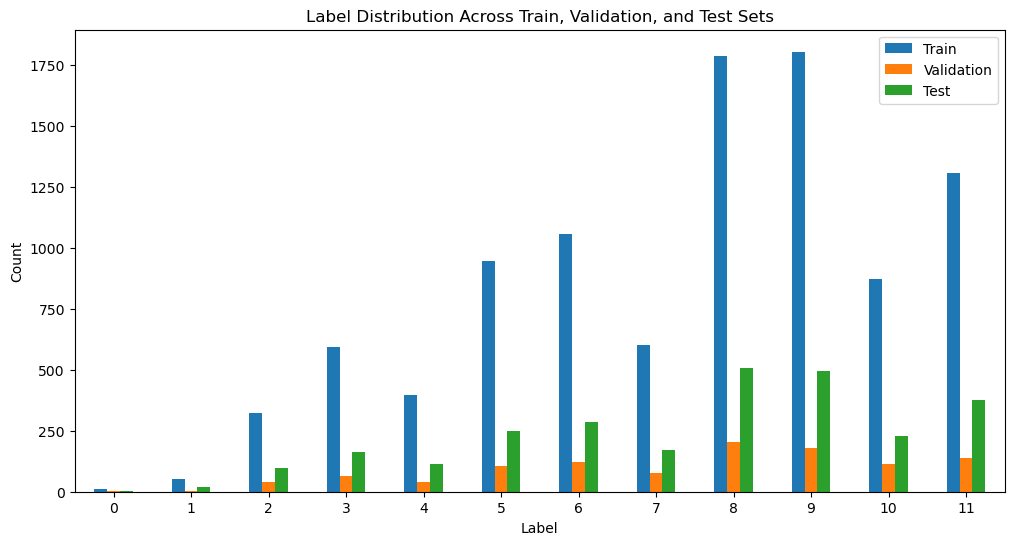

In [ ]:
train_counts= df_train.reset_index().drop_duplicates('flow')['label'].value_counts().sort_index()
plt.show()
validation_counts= df_validation.reset_index().drop_duplicates('flow')['label'].value_counts().sort_index()
plt.show()
test_counts=df_test.reset_index().drop_duplicates('flow')['label'].value_counts().sort_index()
plt.show()

df_combined = pd.DataFrame({
    'Train': train_counts,
    'Validation': validation_counts,
    'Test': test_counts
})
ax = df_combined.plot(kind='bar', figsize=(12, 6))
ax.set_title('Label Distribution Across Train, Validation, and Test Sets')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
df_train.head(1000).to_csv('views/fids_train_dummy.csv')

In [ ]:
tmp=df_train.groupby('flow')['ip_id'].count().value_counts()
tmp=tmp.sort_index().cumsum()
tmp = tmp/tmp.max()
display(tmp)

ip_id
2        0.000615
3        0.000717
4        0.000820
5        0.000922
6        0.004612
           ...   
8808     0.999590
9579     0.999693
25497    0.999795
25537    0.999898
27265    1.000000
Name: count, Length: 111, dtype: float64

In [ ]:
# df_train.drop('payload_raw')

In [ ]:
MAX_PAYLOAD_LENGTH = df_train['payload_raw'].apply(len).max()
def payload_to_binary_columns(df, column_name):
    """
    Converts a column with binary data into separate bit columns.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to convert.

    Returns:
        pd.DataFrame: The transformed DataFrame with bit columns.
    """
    # Find the maximum length of the payload
    # max_payload_length = df[column_name].apply(len).max()
    bit_columns = ['bit_' + str(i) for i in range(MAX_PAYLOAD_LENGTH * 8)]
    
    def bytes_to_bits(byte_data):
        byte_array = np.frombuffer(byte_data, dtype=np.uint8)
        return np.unpackbits(byte_array)
    
    # Convert and pad the binary data
    binary_data = df[column_name].apply(lambda x: np.pad(bytes_to_bits(x), (0, MAX_PAYLOAD_LENGTH * 8 - len(x) * 8), 'constant'))

    # Stack the binary data into a matrix
    binary_matrix = np.vstack(binary_data.values)
    
    # Create a DataFrame from the binary matrix
    binary_df = pd.DataFrame(binary_matrix, columns=bit_columns)
    df=df.reset_index()
    # Concatenate the binary DataFrame with the original DataFrame
    return pd.concat([df.drop(columns=[column_name]), binary_df], axis=1).set_index('flow')
# Transform the DataFrame

if NO_PAYLOAD:
    df_train.drop('payload_raw',axis=1,inplace=True)
    df_test.drop('payload_raw',axis=1,inplace=True)
    df_validation.drop('payload_raw',axis=1,inplace=True)
else:
    df_train=payload_to_binary_columns(df_train, 'payload_raw')
    df_validation=payload_to_binary_columns(df_validation, 'payload_raw')
    df_test=payload_to_binary_columns(df_test, 'payload_raw')

# Training Dataset

In [ ]:
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.utils.data import Dataset


class IEC104Dataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
        self.flow_int_id = list(set(self.df.index))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.flow_int_id)

    def __getitem__(self, idx):
        df_idx = self.flow_int_id[idx]
        flow = self.df.loc[df_idx, self.df.columns != 'label']
        label = self.df.loc[df_idx, 'label']

        if isinstance(flow, pd.Series):
            flow = flow.to_frame().T
        
        # if isinstance(label, np.float64):
        #     print('label:',label)
        if isinstance(label,np.float64):
            label = label.astype(int)
        elif not isinstance(label, np.int64):
            label = label.iloc[0]
        label = torch.tensor(label)

        if self.transform:
            flow = self.transform(flow)
        if self.target_transform:
            label = self.target_transform(label)
        # print(flow)
        # print(label)
        return flow, label

def feature_transform(flow):
    # Convert flow to a DataFrame if it's not already
    flow = pd.DataFrame(flow)

    # Convert to tensors
    dynamic_tensor = torch.tensor(flow.values, dtype=torch.float32)

    if dynamic_tensor.shape[0] > SEQ_LEN:
        # Randomly select a starting index for the sequence
        start_idx = np.random.randint(0, dynamic_tensor.shape[0] - SEQ_LEN + 1)
        dynamic_tensor = dynamic_tensor[start_idx:start_idx + SEQ_LEN]
    else:
        # If the tensor is shorter than SEQ_LEN, pad with -1 as before
        X = torch.zeros(SEQ_LEN, dynamic_tensor.shape[1], dtype=torch.float32)
        min_shape_0 = min(dynamic_tensor.shape[0], SEQ_LEN)
        X[:min_shape_0] = dynamic_tensor[-min_shape_0:]
        dynamic_tensor = X
    # dynamic_tensor = (dynamic_tensor+1)/2
    return dynamic_tensor

    # return dynamic_tensor


### Dataset Loader

# Model Design

In [ ]:
# model_vitv2_output_shape = [ 512, 8, 8]
NUM_CLASSES = df_train.label.nunique()

In [ ]:
def get_device():
    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:1"
    return device
DEVICE = get_device()

In [ ]:
import seaborn as sns

In [ ]:
import wandb

### Lightning

In [ ]:
# class_sample_output=df_train.reset_index().groupby('label')['flow'].nunique().tolist()
# # # print(class_sample_output)
# SAMPLING_WEIGHTS = 1 / torch.Tensor(class_sample_output).to('cuda')

class LFVIT(L.LightningModule):
    def __init__(self, model,name):
        super().__init__()
        self.model = model
        self.name = name
        self.step_outputs = defaultdict(list)
        self.step_target = defaultdict(list)
    def forward(self, inputs):
        return self.model(inputs)
    def training_step(self, batch, batch_idx):
        x, y = batch
        # print(x.shape)
        target_prediction = self.model(x)
        # loss = nn.functional.cross_entropy(target_prediction, y,weight=SAMPLING_WEIGHTS)
        loss = nn.functional.cross_entropy(target_prediction, y)
        self.step_outputs['train'].append(target_prediction)
        self.step_target['train'].append(y)
        self.log('train_loss',loss,on_epoch=True,on_step=False)
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # print(x.shape)

        target_prediction = self.model(x)
        self.step_outputs['validation'].append(target_prediction)
        self.step_target['validation'].append(y)
        loss = nn.functional.cross_entropy(target_prediction, y)

        self.log('val_loss',loss,on_epoch=True,on_step=False)
        # loss = nn.functional.cross_entropy(target_prediction, y)
        # self.log('val_loss',loss)
    def test_step(self, batch, batch_idx):
        x, y = batch
        target_prediction = self.model(x)
        self.step_outputs['test'].append(target_prediction)
        self.step_target['test'].append(y)       
    # def on_test_epoch_end(self):
    # def on_train_epoch_end(self):

    def on_test_epoch_end(self):
        self._shared_on_epoch_end(end_type='test')
    def on_validation_epoch_end(self):
        self._shared_on_epoch_end('validation')
    def _shared_on_epoch_end(self,end_type):
        all_preds = torch.cat(self.step_outputs[end_type])
        all_targets = torch.cat(self.step_target[end_type])
        metrics = dict()
        suffix= end_type+'_'    
        accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'accuracy'] = accuracy(all_preds, all_targets)
         
        metric = torchmetrics.Precision(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'precision'] = metric(all_preds, all_targets)
        
        metric = torchmetrics.Recall(task="multiclass", num_classes=NUM_CLASSES,average='macro').to(DEVICE)
        metrics[suffix+'recall'] = metric(all_preds, all_targets) 
        
        stat_scores = torchmetrics.classification.MulticlassStatScores(num_classes=NUM_CLASSES,average='micro').to(DEVICE)

        # Update the state with the true and predicted labels
        stat_scores.update(all_preds, all_targets)

        # Compute the scores
        scores = stat_scores.compute()

        # Extract TP, FP, TN, FN for each class
        tp = scores[ 0]
        fp = scores[ 1]
        tn = scores[ 2]
        fn = scores[ 3]

        # Compute TPR and FPR for each class
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        metrics[suffix+'tpr'] = tpr
           
        metrics[suffix+'fpr'] = fpr
        confusionmatrix = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        # metrics[suffix+'cm'] = str(confusionmatrix_result)
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix", images=['tmp/confusionmatrix.png'])
        
        confusionmatrix = torchmetrics.ConfusionMatrix(normalize='true',task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
        confusionmatrix_result = confusionmatrix(all_preds, all_targets).cpu().numpy()
        df_cm = pd.DataFrame(confusionmatrix_result, index = range(NUM_CLASSES), columns=range(NUM_CLASSES))
        plt.figure(figsize = (10,7))
        fig_ = sns.heatmap(df_cm, annot=True, cmap='Spectral').get_figure()
        plt.close(fig_)
        fig_.savefig('tmp/confusionmatrix_normalized.png')
        wandb_logger.log_image(key=suffix+"confusionmatrix_normalized", images=['tmp/confusionmatrix_normalized.png'])
        
        self.log_dict(metrics)
        self.step_outputs[end_type].clear()
        self.step_target[end_type].clear()
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,mode='min')
        return {'optimizer':optimizer,"lr_scheduler":{"scheduler": scheduler, "interval": "epoch","frequency": 1,"monitor": "val_loss"}}


###  Model

In [ ]:
import math

import torch.nn as nn


class FVIT(nn.Module):
    def __init__(self,encoder,decoder):
        super(FVIT, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        hidden_states=self.encoder(x[0])
        concatenated_input = torch.cat((torch.flatten(hidden_states, start_dim=1), torch.flatten(x[1], start_dim=1)),dim=1)
        return self.decoder(concatenated_input)
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]  # Shape: (batch_size, seq_len, d_model)
        return x

class TransformerModel(nn.Module):
    def __init__(self,d_model, nhead, nhid, nlayers, dropout):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model,SEQ_LEN)
        # print(d_model,nhead,dropout,nhid)
        self.transformer_encoder = nn.TransformerEncoder(
                        nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout,dim_feedforward=nhid,activation=nn.ReLU(),batch_first=True),
                num_layers=nlayers,norm=nn.LayerNorm(normalized_shape=NUM_FEATURES)
                )
        self.d_model = d_model
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(NUM_FEATURES*SEQ_LEN, NUM_CLASSES),
            nn.Softmax(dim=1)
)   
        
    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x= self.decoder(x)
        return x
    
class BinaryEncodingTransformerModel(nn.Module):
    def __init__(self):
        super(BinaryEncodingTransformerModel, self).__init__()
        self.model_type = 'Transformer'
 
        
        self.decoder = nn.Sequential(
    PositionalEncoding(NUM_FEATURES,SEQ_LEN),
    Encoder(dim = NUM_FEATURES,
        depth = 6,
        heads = 4,          
        ff_dropout = 0.2,          # feed-forward dropout rate
    attn_dropout = 0.2,         # attention dropout rate
    # attn_sparse_topk = 8
        ),
            nn.Flatten(),
            nn.Linear(NUM_FEATURES*SEQ_LEN, NUM_CLASSES),
            nn.Softmax(dim=1))

    def forward(self, x):

        x = self.decoder(x)
        return x


class GRUModel(nn.Module):
    def __init__(self, num_features, num_classes, seq_len):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(num_features, 10*num_features, 3, dropout = 0.5,batch_first=True)
        self.linear = nn.Linear(10*num_features * seq_len, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        gru_out, _ = self.gru(x)  # Get the output and hidden state from GRU
        gru_out = gru_out.contiguous().view(gru_out.size(0), -1)  # Flatten the output
        linear_out = self.linear(gru_out)
        output = self.softmax(linear_out)
        return output


class RNNModel(nn.Module):
    def __init__(self, num_features, num_classes, seq_len):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(num_features, 1000, 3, dropout=0.2, batch_first=True,bidirectional=False,nonlinearity='tanh')
        self.linear = nn.Linear(1000 * seq_len, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)  # Get the output and hidden state from RNN
        rnn_out = rnn_out.contiguous().view(rnn_out.size(0), -1)  # Flatten the output
        linear_out = self.linear(rnn_out)
        output = self.softmax(linear_out)
        return output

# Assuming these classes and modules are already defined:
# PositionalEncoding, Encoder, LFVIT, GRUModel, RNNModel



In [ ]:
# df_train.shape[1]-1,df_validation.shape[1]-1,df_test.shape[1]-1

In [ ]:
NUM_FEATURES = df_train.shape[1]-1
NUM_FEATURES

26

In [ ]:
# output_dim_transformer_encoder = [SEQ_LEN,SEQ_LEN,NUM_FEATURES]

In [ ]:
NUM_FEATURES

26

In [ ]:
from x_transformers import Encoder, Decoder

In [ ]:
SEQ_LEN = 20
BATCH_SIZE=128
NUM_WORKERS =6
PREFETCH_FACTOR=2
train_dataset = IEC104Dataset(df_train,transform = feature_transform)
validation_dataset = IEC104Dataset(df_validation,transform = feature_transform)
test_dataset = IEC104Dataset(df_test,transform = feature_transform)


class_sample_output=df_train.reset_index().groupby('label')['flow'].nunique().tolist()
# print(class_sample_output)
sampling_weights = 1 / torch.Tensor(class_sample_output)
# print(sampling_weights)

labels = train_dataset.df.groupby('flow')['label'].unique()
# print(train_dataset.flow_int_id[0])
labels=[labels.loc[i][0] for i in train_dataset.flow_int_id]
samples_weight = np.array([sampling_weights[t] for t in labels]).flatten()

samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
# print(samples_weigth)
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))


# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)
train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,sampler = sampler)#,collate_fn = collate_fn)
# train_loader = data_utils.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR,shuffle=True)
# next(iter(train_loader))

validation_loader = data_utils.DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)
test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)


In [ ]:
def create_model(model_name):
    if model_name == "Transformer" or model_name == "Transformer*":
        model = LFVIT(nn.Sequential(
            # nn.Linear(NUM_FEATURES*SEQ_LEN, 50*SEQ_LEN),
            PositionalEncoding(NUM_FEATURES, SEQ_LEN),
            Encoder(
                dim=NUM_FEATURES,
                ff_mult=8,
                depth=6,
                heads=6,
                ff_dropout=0.2,          # feed-forward dropout rate
                attn_dropout=0.2,        # attention dropout rate
                ff_glu=True,
            ),
            
            nn.Flatten(),
            nn.Linear(NUM_FEATURES * SEQ_LEN, NUM_CLASSES),
            nn.Softmax(dim=1)
        ), model_name)
    elif model_name == "GRU" or model_name == "GRU*":
        model = LFVIT(GRUModel(NUM_FEATURES, NUM_CLASSES, SEQ_LEN), model_name)
    
    elif model_name == "RNN" or model_name == "RNN*":
        model = LFVIT(RNNModel(NUM_FEATURES, NUM_CLASSES, SEQ_LEN),model_name)
    
    elif model_name == "SEQ-MLP" or model_name == "SEQ-MLP*":
        layer_sizes = [NUM_FEATURES * SEQ_LEN, NUM_FEATURES * SEQ_LEN, 512, NUM_CLASSES]
        layers = [nn.Flatten()]  # Add flatten layer at the beginning
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(nn.GELU())  # Activation function
            layers.append(nn.Dropout(0.1))  # Dropout with a rate of 0.1
        layers.append(nn.Softmax(dim=1))
        fcn = nn.Sequential(*layers)
        model = LFVIT(fcn, model_name)
    
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    return model
# model_name = "Transformer"
model_name = "Transformer"
# model_name = "SEQ-MLP"
model_name += "" if NO_PAYLOAD else "*"
model_fvit = create_model(model_name)


In [ ]:
# if model_fvit.name == "TSS":
#     wandb.finish()
#     wandb_logger = WandbLogger(log_model="all")
#     MAX_EPOCHS=10
#     def run_fvit_self_supervision_trainer_fit(train_loader,validation_loader,model):
#         lr_monitor = LearningRateMonitor(logging_interval='epoch')
#         trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[lr_monitor],accelerator='cuda',
#                             devices=[1],log_every_n_steps=20
#                             #,check_val_every_n_epoch=1
#                             # ,limit_train_batches=100,limit_val_batches=100#,max_time={"minutes": 60}
#                             ,logger=wandb_logger)
#         trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
#         return checkpoint_callback,trainer
# checkpoint_callback,trainer=run_fvit_self_supervision_trainer_fit(
#         train_loader,
#         validation_loader,
#         model=model_fvit)

In [ ]:
model_fvit.model

Sequential(
  (0): PositionalEncoding()
  (1): Encoder(
    (layers): ModuleList(
      (0): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((26,), eps=1e-05, elementwise_affine=True)
          (1-2): 2 x None
        )
        (1): Attention(
          (to_q): Linear(in_features=26, out_features=384, bias=False)
          (to_k): Linear(in_features=26, out_features=384, bias=False)
          (to_v): Linear(in_features=26, out_features=384, bias=False)
          (attend): Attend(
            (attn_dropout): Dropout(p=0.2, inplace=False)
          )
          (to_out): Linear(in_features=384, out_features=26, bias=False)
        )
        (2): Residual()
      )
      (1): ModuleList(
        (0): ModuleList(
          (0): LayerNorm((26,), eps=1e-05, elementwise_affine=True)
          (1-2): 2 x None
        )
        (1): FeedForward(
          (ff): Sequential(
            (0): GLU(
              (act): GELU(approximate='none')
              (proj): Linear(in_features=2

## Running


In [ ]:
wandb.init() 

In [ ]:
wandb.finish()
wandb_logger = WandbLogger(log_model="all")
# wandb.init()
MAX_EPOCHS=13
# timer =  L.pytorch.calalbacks.Timer()
def run_fvit_trainer_fit(train_loader,validation_loader,model):
    # checkpoint_callback = L.pytorch.callbacks.ModelCheckpoint(
    #     monitor='train_loss',
    #     filename='iec104-{epoch:02d}-{loss}',
    #     save_top_k=1,
    #     mode='min', 
    # )
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    # early_stop_callback = L.pytorch.callbacks.early_stopping.EarlyStopping(monitor="val_loss", min_delta=0.001, patience=3, verbose=False, mode="min")
    # cpb=CustomProgressBar()
    trainer = L.Trainer(max_epochs=MAX_EPOCHS,callbacks=[lr_monitor],accelerator='cuda',
                        devices=[1],log_every_n_steps=20
                        #,check_val_every_n_epoch=1
                        # ,limit_train_batches=100,limit_val_batches=100#,max_time={"minutes": 60}
                        ,logger=wandb_logger)
    trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader)
    # return checkpoint_callback,trainer
    return trainer
trainer=run_fvit_trainer_fit(
    train_loader,
    validation_loader,
     model=model_fvit)

wandb: ERROR Control-C detected -- Run data was not synced
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Problem at: /home/hwerneck/miniconda3/lib/python3.12/site-packages/wandb/sdk/wandb_init.py 855 getcaller


/home/hwerneck/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
trainer.test(ckpt_path="best",dataloaders=test_loader)

Restoring states from the checkpoint path at ./lightning_logs/proo70tn/checkpoints/iec104-epoch=09-loss=0.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at ./lightning_logs/proo70tn/checkpoints/iec104-epoch=09-loss=0.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.38423392176628113    │
│         test_fpr          │    0.06746923178434372    │
│      test_precision       │    0.31875622272491455    │
│        test_recall        │    0.38423392176628113    │
│         test_tpr          │    0.2578384280204773     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.38423392176628113,
  'test_precision': 0.31875622272491455,
  'test_recall': 0.38423392176628113,
  'test_tpr': 0.2578384280204773,
  'test_fpr': 0.06746923178434372}]

In [ ]:
best_checkpoint_path = checkpoint_callback.best_model_path
print(f"Best checkpoint path: {best_checkpoint_path}")
best_model= LFVIT.load_from_checkpoint(best_checkpoint_path,model=model_fvit.model,name=model_fvit.name)
best_model.to(DEVICE)

Best checkpoint path: ./lightning_logs/proo70tn/checkpoints/iec104-epoch=09-loss=0.ckpt


LFVIT(
  (model): RNNModel(
    (rnn): RNN(26, 1000, num_layers=3, batch_first=True, dropout=0.2)
    (linear): Linear(in_features=20000, out_features=12, bias=True)
    (softmax): Softmax(dim=1)
  )
)

In [ ]:
import time
from constants import NUMBER_PACKETS_OPTIONS
import constants

In [ ]:
DEVICE

'cuda:1'

In [ ]:
# best_model = model_fvit

# best_checkpoint_path = checkpoint_callback.best_model_path
# print(f"Best checkpoint path: {best_checkpoint_path}")
# best_model = LFVIT.load_from_checkpoint(best_checkpoint_path,model=GRUModel(NUM_FEATURES, NUM_CLASSES, SEQ_LEN),name='GRU')

In [ ]:
def run_experiment(df,num_packets):
    if num_packets != 'full':
        df = df[df['packet_number'].isin(list(range(num_packets)))]
        df = df.groupby(level='flow').filter(lambda x: len(x) <= num_packets)
    test_dataset = IEC104Dataset(df,transform = feature_transform)
    test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = 1,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)#,collate_fn = collate_fn)

    # test_dataset = IEC104Dataset(df_test,transform = feature_transform)
    # test_loader = data_utils.DataLoader(dataset = test_dataset, batch_size = 1,num_workers=NUM_WORKERS,prefetch_factor=PREFETCH_FACTOR)


    

    # Run predictions and measure time
    # all_preds = []
    prediction_times=[]
    start_time = time.time()
    best_model.to(DEVICE)
    best_model.eval()
    with torch.no_grad():
        for batch in test_loader:
            inputs, _ = batch
            inputs= inputs.to(DEVICE)
            batch_start_time = time.time()
            # print(inputs.shape)
            preds = best_model(inputs)
            batch_end_time = time.time()
            batch_time = batch_end_time - batch_start_time
            prediction_times.append(batch_time)

            # print(f"Batch prediction time: {batch_time:.4f} seconds")
            # all_preds.append(preds)
    prediction_times= pd.DataFrame(prediction_times)
    metrics_results = trainer.test(best_model,dataloaders=test_loader)
    metrics_results= metrics_results[0]
    formatted_metrics = constants.metrics_log_formatter(model_name, "", num_packets, TIMEOUT,
        accuracy=metrics_results['test_accuracy'],
                                          precision=metrics_results['test_precision'],
                                          recall=metrics_results['test_recall'],
                                          cm=None,
                                          tpr_micro=metrics_results['test_tpr'],
                                          fpr_micro=metrics_results['test_fpr'],
                                          avg_pred_time=prediction_times.mean().item(),
                                          std_pred_time=prediction_times.std().item(),
                                          avg_throughput=1/prediction_times.mean().item(),
                                          std_throughput=(1/prediction_times).std().item(),
                                          avg_total_pred_time=prediction_times.mean().item(),
                                          std_total_pred_time=prediction_times.std().item(),
                                          avg_total_throughput=1/prediction_times.mean().item(),
                                          std_total_throughput=(1/prediction_times).std().item())

    return formatted_metrics
    # total_time = time.time() - start_time
    # print(f"Total prediction time for the dataset: {total_time:.4f} seconds")

    # # Flatten all predictions into a single tensor
    # all_preds = torch.cat(all_preds, dim=0)

    # print(f"Predictions shape: {all_preds.shape}")


model_name = best_model.name

results = []
full_packets = 'full'
res= run_experiment(df_test,full_packets)
# performance_metrics =constants.metadata_log_formatter(model_name, "", full_packets, TIMEOUT)
# res = evaluate_model_performance(best_model, X_tests[number_packets], y_tests[number_packets], NUM_RUNS)
# performance_metrics.update(res)
results.append(res)

for number_packets in NUMBER_PACKETS_OPTIONS:
    # df_test=pd.read_parquet(f'data/iec104_test_{TIMEOUT}.parquet')
    res= run_experiment(df_test,number_packets)
    # performance_metrics = constants.metadata_log_formatter(model_name, "", number_packets, TIMEOUT)
    # res = evaluate_model_performance(best_model, X_tests[number_packets], y_tests[number_packets], NUM_RUNS)
    # performance_metrics.update(res)
    results.append(res)

df_results = pd.DataFrame(results)

output_path= 'data/results_fids.json'
df_results.to_json(output_path, mode='a',orient="records", lines=True)#, header=not os.path.exists(output_path))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.38423392176628113    │
│         test_fpr          │    0.06746923178434372    │
│      test_precision       │    0.31875622272491455    │
│        test_recall        │    0.38423392176628113    │
│         test_tpr          │    0.2578384280204773     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.0833333358168602     │
│         test_fpr          │    0.07434358447790146    │
│      test_precision       │   0.015190652571618557    │
│        test_recall        │    0.0833333358168602     │
│         test_tpr          │    0.18222057819366455    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.1419132798910141     │
│         test_fpr          │    0.07199624180793762    │
│      test_precision       │    0.07557357847690582    │
│        test_recall        │    0.1419132798910141     │
│         test_tpr          │    0.20804131031036377    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.38423392176628113    │
│         test_fpr          │    0.06746923178434372    │
│      test_precision       │    0.31875622272491455    │
│        test_recall        │    0.38423392176628113    │
│         test_tpr          │    0.2578384280204773     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.38423392176628113    │
│         test_fpr          │    0.06746923178434372    │
│      test_precision       │    0.31875622272491455    │
│        test_recall        │    0.38423392176628113    │
│         test_tpr          │    0.2578384280204773     │
└───────────────────────────┴───────────────────────────┘